# WOD-E2E segment inspection (step-by-step)

帮助快速验证 `seg_index_val_enriched.csv` 读取和 `SegmentRecord` 聚合逻辑。

字段检查

In [ ]:
from pathlib import Path
import json
import math
import pickle
from collections import defaultdict
from wod_e2e_exporter.utils import win_to_wsl_path
from waymo_open_dataset.protos import end_to_end_driving_data_pb2 as wod_e2ed_pb2
from google.protobuf.descriptor import FieldDescriptor

cache_path = Path(win_to_wsl_path(
    r"D:\Datasets\WOD_E2E_Camera_v1\val_cache\Interections_a9531d2b707f75a117280553930f312d.pkl"
))
cache = pickle.load(cache_path.open("rb"))

OUT_JSON = Path("field_stats_full_2.0.json")
MAX_REPEAT_ELEMS = 1

TYPE_NAME = {
    1: "double",
    2: "float",
    3: "int64",
    4: "uint64",
    5: "int32",
    6: "fixed64",
    7: "fixed32",
    8: "bool",
    9: "string",
    10: "group",
    11: "message",
    12: "bytes",
    13: "uint32",
    14: "enum",
    15: "sfixed32",
    16: "sfixed64",
    17: "sint32",
    18: "sint64",
}

def field_type_name(fd):
    return TYPE_NAME.get(fd.type, str(fd.type))

def collect_schema_fields(desc, prefix=""):
    out = []
    for fd in desc.fields:
        path = f"{prefix}.{fd.name}" if prefix else fd.name
        entry = {
            "label": "repeated" if fd.label == FieldDescriptor.LABEL_REPEATED else "optional",
            "field_type": field_type_name(fd),
            "message_type": fd.message_type.full_name if fd.type == FieldDescriptor.TYPE_MESSAGE else None,
            "present_frames": 0,
            "max_len": 0,
            "sample": None,
        }
        out.append((path, entry))
        if fd.type == FieldDescriptor.TYPE_MESSAGE and fd.message_type is not None:
            out.extend(collect_schema_fields(fd.message_type, path))
    return out

def summarize_val(val):
    if isinstance(val, bytes):
        return {"bytes_len": len(val)}
    if isinstance(val, str):
        return val if len(val) <= 120 else val[:120] + "...(truncated)"
    if isinstance(val, float):
        if math.isnan(val):
            return "nan"
        if math.isinf(val):
            return "inf" if val > 0 else "-inf"
        return val
    if isinstance(val, (int, bool)):
        return val
    return str(val)

def traverse_msg(msg, prefix, stats, visited):
    for fd, val in msg.ListFields():
        path = f"{prefix}.{fd.name}" if prefix else fd.name
        visited.add(path)
        info = stats.setdefault(path, {
            "label": "repeated" if fd.label == FieldDescriptor.LABEL_REPEATED else "optional",
            "field_type": field_type_name(fd),
            "message_type": fd.message_type.full_name if fd.type == FieldDescriptor.TYPE_MESSAGE else None,
            "present_frames": 0,
            "max_len": 0,
            "sample": None,
        })

        if fd.label == FieldDescriptor.LABEL_REPEATED:
            try:
                n = len(val)
            except Exception:
                n = 0
            info["max_len"] = max(info["max_len"], n)
            if info["sample"] is None:
                if fd.type == FieldDescriptor.TYPE_MESSAGE:
                    info["sample"] = {"type": "message"}
                else:
                    info["sample"] = summarize_val(val[0]) if n > 0 else None
            if fd.type == FieldDescriptor.TYPE_MESSAGE and n > 0:
                elems = val if MAX_REPEAT_ELEMS is None else val[:MAX_REPEAT_ELEMS]
                for child in elems:
                    traverse_msg(child, path, stats, visited)
        else:
            if info["sample"] is None:
                info["sample"] = {"type": "message"} if fd.type == FieldDescriptor.TYPE_MESSAGE else summarize_val(val)
            if fd.type == FieldDescriptor.TYPE_MESSAGE:
                traverse_msg(val, path, stats, visited)

# 初始化 schema 全字段
e0 = wod_e2ed_pb2.E2EDFrame()
e0.ParseFromString(cache["e2e_bytes"][0])
schema_entries = collect_schema_fields(e0.DESCRIPTOR)
stats = {k: v for k, v in schema_entries}

# 扫描所有帧
for raw in cache["e2e_bytes"]:
    e = wod_e2ed_pb2.E2EDFrame()
    e.ParseFromString(raw)
    visited = set()
    traverse_msg(e, "", stats, visited)
    for p in visited:
        stats[p]["present_frames"] += 1

# 补全 sample
for info in stats.values():
    if info["sample"] is None:
        info["sample"] = "none"

with OUT_JSON.open("w", encoding="utf-8") as f:
    json.dump(stats, f, ensure_ascii=True, indent=2)

print("saved:", OUT_JSON.resolve())


导出文件

In [1]:
from pathlib import Path
import pickle
import re
from wod_e2e_exporter.io_reader import load_segment_from_cache_dict
from wod_e2e_exporter.exporters import export_segment
from wod_e2e_exporter.utils import win_to_wsl_path

cache_path = Path(win_to_wsl_path(
    r"D:\Datasets\WOD_E2E_Camera_v1\val_cache\Interections_a9531d2b707f75a117280553930f312d.pkl"
))

# 从cache path提取split和scenario_cluster
cache_filename = cache_path.stem  # 移除.pkl后缀
match = re.match(r"([A-Za-z_]+)_([a-f0-9]+)", cache_filename)

if match:
    scenario_cluster = match.group(1)
    seg_id_base = match.group(2)
else:
    scenario_cluster = "Pedestrian"  # 默认值
    
# 根据scenario_cluster自动生成导出目录
OUTPUT_DIR = Path(f"wod_export_{scenario_cluster}")

print(f"Scenario Cluster: {scenario_cluster}")
print(f"Output Dir: {OUTPUT_DIR}")

with cache_path.open("rb") as f:
    cache_dict = pickle.load(f)

seg = load_segment_from_cache_dict(cache_dict, split="val", scenario_cluster=scenario_cluster)

out = export_segment(seg, OUTPUT_DIR, overwrite=True)
seg_dir = Path(out["seg_dir"])
print("exported to:", seg_dir)


2026-01-22 14:08:00.435399: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-22 14:08:00.450340: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-22 14:08:00.772908: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-22 14:08:00.774396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-22 14:08:02.691658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:3

Scenario Cluster: Interections
Output Dir: wod_export_Interections
exported to: wod_export_Interections/Interections/Interections_segment-a9531d2b707f75a117280553930f312d


In [ ]:
import matplotlib as mpl
if not hasattr(mpl.rcParams, "_get"):
    mpl.rcParams._get = mpl.rcParams.get
import matplotlib.pyplot as plt
import pandas as pd
import json
from pathlib import Path

# 从前面的单元格中获取seg_dir，如果不存在则从out字典重建
if 'seg_dir' not in locals():
    seg_dir = Path(out["seg_dir"])

base = seg_dir / "critical_5s" / "trajectory"
future = pd.read_csv(base / "ego_future_5s_4hz.csv")

manifest_path = seg_dir / "critical_5s" / "segment_manifest.json"
manifest = json.loads(manifest_path.read_text(encoding="utf-8"))
rater_scores = [t.get("score", -1.0) for t in manifest["rater_labels"].get("trajectories", [])]

r0 = pd.read_csv(base / "rater_traj_0_0to5s_4hz.csv")
r1 = pd.read_csv(base / "rater_traj_1_0to5s_4hz.csv")
r2 = pd.read_csv(base / "rater_traj_2_0to5s_4hz.csv")

def xy(df):
    if "pos_x" in df.columns:
        return df["pos_x"], df["pos_y"]
    return df["x_m"], df["y_m"]

plt.figure(figsize=(6,6))
plt.plot(*xy(future), "o-", label="future", markersize=3)
plt.plot(*xy(r0), "o-", label=f"rater 0 ({rater_scores[0]:.1f})" if len(rater_scores)>0 else "rater 0", markersize=1)
plt.plot(*xy(r1), "o-", label=f"rater 1 ({rater_scores[1]:.1f})" if len(rater_scores)>1 else "rater 1", markersize=1)
plt.plot(*xy(r2), "o-", label=f"rater 2 ({rater_scores[2]:.1f})" if len(rater_scores)>2 else "rater 2", markersize=1)

plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Future vs Rater Trajectories (BEV)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [ ]:
import matplotlib as mpl
if not hasattr(mpl.rcParams, "_get"):
    mpl.rcParams._get = mpl.rcParams.get  # 兼容你的环境
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# 从前面的单元格中使用seg_dir自动构建路径
base = seg_dir / "critical_5s" / "trajectory"
past = pd.read_csv(base / "ego_past_4s_4hz.csv")
future = pd.read_csv(base / "ego_future_5s_4hz.csv")

def xy(df):
    if "pos_x" in df.columns:
        return df["pos_x"].dropna(), df["pos_y"].dropna()
    return df["x_m"].dropna(), df["y_m"].dropna()

px, py = xy(past)
fx, fy = xy(future)

plt.figure(figsize=(6,6))
plt.plot(px, py, "o-", label="past 4Hz", markersize=3)
plt.plot(fx, fy, "o-", label="future 4Hz", markersize=3)

plt.axis("equal")
plt.xlabel("x"); plt.ylabel("y")
plt.title("Past / Future / Observed Trajectory (BEV)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


验证critical moment的位置，算出来是起点14.0

In [ ]:
from pathlib import Path
import pickle
from waymo_open_dataset.protos import end_to_end_driving_data_pb2 as wod_e2ed_pb2
from wod_e2e_exporter.utils import win_to_wsl_path

# 改成你的缓存路径
cache_path = Path(win_to_wsl_path(
    r"D:\Datasets\WOD_E2E_Camera_v1\val_cache\Pedestrian_24fe50afd86ac25fe1162a605cc2e99e.pkl"
))

obj = pickle.loads(cache_path.read_bytes())
e2e_bytes = obj["e2e_bytes"]

all_scores = []
first_scored_idx = None

for idx, b in enumerate(e2e_bytes):
    e = wod_e2ed_pb2.E2EDFrame()
    e.ParseFromString(b)
    prefs = list(e.preference_trajectories)
    scores = []
    for i in range(3):
        if i < len(prefs) and prefs[i].HasField("preference_score"):
            scores.append(float(prefs[i].preference_score))
        else:
            scores.append(-1.0)
    all_scores.append((idx, scores))
    if first_scored_idx is None and any(s != -1.0 for s in scores):
        first_scored_idx = idx

# 输出每一帧的分数（可改成只看前 N 帧）
for idx, scores in all_scores:
    print(idx, scores)

print("first_scored_idx:", first_scored_idx)


意图输出

In [ ]:
from pathlib import Path
import pickle
from waymo_open_dataset.protos import end_to_end_driving_data_pb2 as wod_e2ed_pb2
from wod_e2e_exporter.utils import win_to_wsl_path

# 改成你的缓存路径
cache_path = Path(win_to_wsl_path(
    r"D:\Datasets\WOD_E2E_Camera_v1\val_cache\Pedestrian_24fe50afd86ac25fe1162a605cc2e99e.pkl"
))

obj = pickle.loads(cache_path.read_bytes())
e2e_bytes = obj["e2e_bytes"]

rows = []
for idx, b in enumerate(e2e_bytes):
    e = wod_e2ed_pb2.E2EDFrame()
    e.ParseFromString(b)
    intent_val = int(getattr(e, "intent", 0))
    intent_name = wod_e2ed_pb2.EgoIntent.Intent.Name(intent_val)
    rows.append((idx, intent_val, intent_name))

# 输出
for r in rows:
    print(r)


cam_id 与方位

In [ ]:
import json, math
from pathlib import Path

calib_path = Path("wod_export_Interections/Interections/Interections_segment-a9531d2b707f75a117280553930f312d/meta/camera_calib.json")
calib = json.loads(calib_path.read_text(encoding="utf-8"))

def cam_forward_yaw_deg(T):
    # T_ego_from_cam: camera x轴(前向)在ego坐标系中的方向 = 第一列
    vx = T[0][0]
    vy = T[1][0]
    return math.degrees(math.atan2(vy, vx))

def classify(yaw):
    # 约略分类
    if -30 <= yaw <= 30:
        return "front"
    if 30 < yaw <= 90:
        return "front-left"
    if 90 < yaw <= 150:
        return "left"
    if yaw > 150 or yaw < -150:
        return "rear"
    if -90 <= yaw < -30:
        return "front-right"
    if -150 <= yaw < -90:
        return "right"
    return "unknown"

for cam_id, info in calib["cameras"].items():
    T = info.get("T_ego_from_cam")
    if not T:
        print(cam_id, "no T_ego_from_cam")
        continue
    yaw = cam_forward_yaw_deg(T)
    print(cam_id, f"yaw_deg={yaw:.1f}", classify(yaw))


In [ ]:
# TODO: Validate Synchronization Quality
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Update this path to the segment cache you want to inspect
from wod_e2e_exporter.utils import win_to_wsl_path
cache_path = Path(win_to_wsl_path(
    r"D:\\Datasets\\WOD_E2E_Camera_v1\\val_cache\\Interections_a9531d2b707f75a117280553930f312d.pkl"
))
if not cache_path.exists():
    raise FileNotFoundError(f"cache_path not found: {cache_path}")

import pickle
from waymo_open_dataset.protos import end_to_end_driving_data_pb2 as wod_e2ed_pb2

def load_frames(cache_path):
    cache = pickle.load(cache_path.open("rb"))
    frames = []
    for raw in cache["e2e_bytes"]:
        e = wod_e2ed_pb2.E2EDFrame()
        e.ParseFromString(raw)
        frames.append(e)
    return frames

frames = load_frames(cache_path)

# 1) Load timestamps for ego (frame.timestamp_micros) and all camera images (frame.images.pose_timestamp).
frame_idx = 0  # <-- set the frame index you want to inspect
frame = frames[frame_idx]

ego_ts = frame.timestamp_micros * 1e-6  # micros -> seconds
cam_ts = [img.pose_timestamp for img in frame.images]

# 2) Calculate delta between each camera and ego timestamp.
deltas = [abs(ts - ego_ts) for ts in cam_ts]

print("frame_idx:", frame_idx)
print("ego_ts (s):", ego_ts)
print("camera_timestamps (s):", cam_ts)
print("deltas (s):", deltas)

# 3) Assert that max(delta) < 10ms (0.01s).
assert max(deltas) < 0.01, f"max delta too large: {max(deltas):.6f}s"

# 4) Visualization: histogram across the entire segment.
all_deltas = []
for f in frames:
    ego_ts = f.timestamp_micros * 1e-6
    for img in f.images:
        all_deltas.append(abs(img.pose_timestamp - ego_ts))

all_deltas = np.array(all_deltas)
print("max_delta_all (s):", all_deltas.max())
print("p95_delta_all (s):", np.percentile(all_deltas, 95))

plt.figure(figsize=(6, 4))
plt.hist(all_deltas * 1000.0, bins=50, color="#3b6ea5", edgecolor="black")
plt.xlabel("|camera - ego| (ms)")
plt.ylabel("count")
plt.title("Timestamp deltas across segment")
plt.tight_layout()
plt.show()


In [ ]:
# NOTE: New sync-validation cell using frame.timestamp_micros and frame.images.pose_timestamp (replaces missing ego_pose fields)
# TODO: Validate Synchronization Quality
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Update this path to the segment cache you want to inspect
from wod_e2e_exporter.utils import win_to_wsl_path
cache_path = Path(win_to_wsl_path(
    r"D:\\Datasets\\WOD_E2E_Camera_v1\\val_cache\\Interections_a9531d2b707f75a117280553930f312d.pkl"
))
if not cache_path.exists():
    raise FileNotFoundError(f"cache_path not found: {cache_path}")

import pickle
from waymo_open_dataset.protos import end_to_end_driving_data_pb2 as wod_e2ed_pb2

def load_frames(cache_path):
    cache = pickle.load(cache_path.open("rb"))
    frames = []
    for raw in cache["e2e_bytes"]:
        e = wod_e2ed_pb2.E2EDFrame()
        e.ParseFromString(raw)
        frames.append(e)
    return frames

frames = load_frames(cache_path)

# 1) Load timestamps for ego (frame.timestamp_micros) and all camera images (frame.images.pose_timestamp).
frame_idx = 0  # <-- set the frame index you want to inspect
frame = frames[frame_idx]

ego_ts = frame.timestamp_micros * 1e-6  # micros -> seconds
cam_ts = [img.pose_timestamp for img in frame.images]

# 2) Calculate delta between each camera and ego timestamp.
deltas = [abs(ts - ego_ts) for ts in cam_ts]

print("frame_idx:", frame_idx)
print("ego_ts (s):", ego_ts)
print("camera_timestamps (s):", cam_ts)
print("deltas (s):", deltas)

# 3) Assert that max(delta) < 10ms (0.01s).
assert max(deltas) < 0.01, f"max delta too large: {max(deltas):.6f}s"

# 4) Visualization: histogram across the entire segment.
all_deltas = []
for f in frames:
    ego_ts = f.timestamp_micros * 1e-6
    for img in f.images:
        all_deltas.append(abs(img.pose_timestamp - ego_ts))

all_deltas = np.array(all_deltas)
print("max_delta_all (s):", all_deltas.max())
print("p95_delta_all (s):", np.percentile(all_deltas, 95))

plt.figure(figsize=(6, 4))
plt.hist(all_deltas * 1000.0, bins=50, color="#3b6ea5", edgecolor="black")
plt.xlabel("|camera - ego| (ms)")
plt.ylabel("count")
plt.title("Timestamp deltas across segment")
plt.tight_layout()
plt.show()


In [ ]:
# NOTE: New sync-validation cell uses frame.frame.timestamp_micros and frame.frame.images if present.
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from wod_e2e_exporter.utils import win_to_wsl_path
cache_path = Path(win_to_wsl_path(
    r"D:\\Datasets\\WOD_E2E_Camera_v1\\val_cache\\Interections_a9531d2b707f75a117280553930f312d.pkl"
))
if not cache_path.exists():
    raise FileNotFoundError(f"cache_path not found: {cache_path}")

import pickle
from waymo_open_dataset.protos import end_to_end_driving_data_pb2 as wod_e2ed_pb2

def load_frames(cache_path):
    cache = pickle.load(cache_path.open("rb"))
    frames = []
    for raw in cache["e2e_bytes"]:
        e = wod_e2ed_pb2.E2EDFrame()
        e.ParseFromString(raw)
        frames.append(e)
    return frames

frames = load_frames(cache_path)

frame_idx = 0
frame = frames[frame_idx]
base = frame.frame if hasattr(frame, 'frame') else frame

ego_ts = base.timestamp_micros * 1e-6  # micros -> seconds
cam_ts = [img.pose_timestamp for img in base.images]

deltas = [abs(ts - ego_ts) for ts in cam_ts]

print("frame_idx:", frame_idx)
print("ego_ts (s):", ego_ts)
print("camera_timestamps (s):", cam_ts)
print("deltas (s):", deltas)

assert max(deltas) < 0.01, f"max delta too large: {max(deltas):.6f}s"

all_deltas = []
for f in frames:
    base = f.frame if hasattr(f, 'frame') else f
    ego_ts = base.timestamp_micros * 1e-6
    for img in base.images:
        all_deltas.append(abs(img.pose_timestamp - ego_ts))

all_deltas = np.array(all_deltas)
print("max_delta_all (s):", all_deltas.max())
print("p95_delta_all (s):", np.percentile(all_deltas, 95))

plt.figure(figsize=(6, 4))
plt.hist(all_deltas * 1000.0, bins=50, color="#3b6ea5", edgecolor="black")
plt.xlabel("|camera - ego| (ms)")
plt.ylabel("count")
plt.title("Timestamp deltas across segment")
plt.tight_layout()
plt.show()


In [ ]:
# NOTE: New cell - full-segment sync assertion + worst-case report
import numpy as np

# Uses existing 'frames' loaded in previous cell
if 'frames' not in globals():
    raise RuntimeError('frames not found; run the sync-validation cell above first')

max_delta = -1.0
max_info = None
all_deltas = []

for idx, f in enumerate(frames):
    base = f.frame if hasattr(f, 'frame') else f
    if not hasattr(base, 'timestamp_micros') or not hasattr(base, 'images'):
        raise AttributeError('missing timestamp_micros or images on frame')
    ego_ts = base.timestamp_micros * 1e-6
    for cam_i, img in enumerate(base.images):
        delta = abs(img.pose_timestamp - ego_ts)
        all_deltas.append(delta)
        if delta > max_delta:
            max_delta = delta
            max_info = (idx, cam_i, img.pose_timestamp, ego_ts)

all_deltas = np.array(all_deltas)
print('max_delta_all (s):', max_delta)
print('p95_delta_all (s):', np.percentile(all_deltas, 95))
print('worst_case: frame_idx, cam_idx, cam_ts, ego_ts =', max_info)

assert max_delta < 0.01, f'max delta too large: {max_delta:.6f}s'


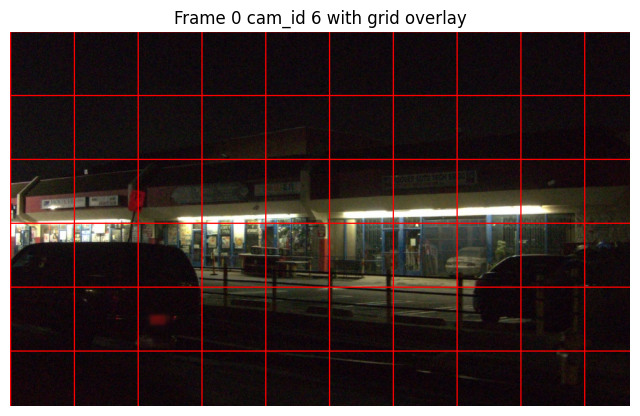

Check if straight structures align with grid lines. If curved and no distortion coefficients exist, flag CRITICAL config error.


In [20]:
# NOTE: New cell - visual rectification check with red grid overlay
from io import BytesIO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Uses existing 'frames' loaded above
if 'frames' not in globals():
    raise RuntimeError('frames not found; run the sync-validation cell above first')

frame_idx = 0  # choose a frame
cam_id = 6    # wide-angle camera id to inspect (e.g., 2 or 4)

frame = frames[frame_idx]
base = frame.frame if hasattr(frame, 'frame') else frame

# Find the camera image by name/id
img_msg = None
for img in base.images:
    if hasattr(img, 'name') and int(img.name) == cam_id:
        img_msg = img
        break
if img_msg is None:
    raise ValueError(f'camera id {cam_id} not found in frame')

# Decode image bytes (assumes JPEG/PNG in img_msg.image)
pil_img = Image.open(BytesIO(img_msg.image)).convert('RGB')
draw = ImageDraw.Draw(pil_img)

# Draw red grid every 100px, line thickness 2px
w, h = pil_img.size
spacing = 100
thickness = 2
color = (255, 0, 0)

for x in range(0, w, spacing):
    for t in range(thickness):
        draw.line([(x + t, 0), (x + t, h)], fill=color)
for y in range(0, h, spacing):
    for t in range(thickness):
        draw.line([(0, y + t), (w, y + t)], fill=color)

plt.figure(figsize=(8, 5))
plt.imshow(pil_img)
plt.title(f'Frame {frame_idx} cam_id {cam_id} with grid overlay')
plt.axis('off')
plt.show()

print('Check if straight structures align with grid lines. If curved and no distortion coefficients exist, flag CRITICAL config error.')


In [ ]:
# NOTE: New cell - list camera intrinsics + distortion fields if available
from google.protobuf.descriptor import FieldDescriptor

if 'frames' not in globals():
    raise RuntimeError('frames not found; run the sync-validation cell above first')

frame = frames[0]
base = frame.frame if hasattr(frame, 'frame') else frame

def list_fields(msg, prefix=''):
    out = []
    for fd in msg.DESCRIPTOR.fields:
        path = f'{prefix}.{fd.name}' if prefix else fd.name
        out.append((path, fd))
    return out

def print_intrinsics(cam):
    print('--- camera ---')
    if hasattr(cam, 'name'):
        print('name:', cam.name)
    # Try common intrinsics fields
    for attr in ['intrinsics', 'camera_intrinsic', 'camera_intrinsics', 'calibration']:
        if hasattr(cam, attr):
            intr = getattr(cam, attr)
            print('intrinsics field:', attr)
            for path, fd in list_fields(intr):
                if any(k in path for k in ['distortion', 'k1', 'k2', 'k3', 'p1', 'p2', 'model']):
                    val = getattr(intr, path.split('.')[-1])
                    print(f'{path}:', val)
            return
    print('no intrinsics field found on camera message')

if hasattr(base, 'context') and hasattr(base.context, 'camera_calibrations'):
    print('found context.camera_calibrations')
    for cam_calib in base.context.camera_calibrations:
        print_intrinsics(cam_calib)
else:
    print('no context.camera_calibrations found; listing camera message fields for images')
    if hasattr(base, 'images') and len(base.images) > 0:
        print('image fields:')
        for path, fd in list_fields(base.images[0]):
            if any(k in path for k in ['distortion', 'k1', 'k2', 'k3', 'p1', 'p2', 'model']):
                print(path)


In [28]:
# NOTE: New cell - resolution normalization via bottom/right padding + K check
from io import BytesIO
import numpy as np
from PIL import Image

# Uses existing 'frames' loaded above
if 'frames' not in globals():
    raise RuntimeError('frames not found; run the sync-validation cell above first')

frame = frames[0]
base = frame.frame if hasattr(frame, 'frame') else frame

def load_pil(img_msg):
    return Image.open(BytesIO(img_msg.image)).convert('RGB')

def letterbox_pad(img, target_h, target_w):
    h, w = img.shape[:2]
    if target_h < h or target_w < w:
        raise ValueError('target size must be >= original size')
    pad_bottom = target_h - h
    pad_right = target_w - w
    pad = ((0, pad_bottom), (0, pad_right), (0, 0))
    out = np.pad(img, pad, mode='constant', constant_values=0)
    return out, (pad_bottom, pad_right)

# Pick two cameras with different resolutions
imgs = list(base.images)
if len(imgs) < 2:
    raise RuntimeError('need at least 2 cameras')

# Group by resolution
res_groups = {}
for img in imgs:
    pil = load_pil(img)
    res_groups.setdefault(pil.size[::-1], []).append((img, pil))  # (h,w)

if len(res_groups) < 2:
    raise RuntimeError('need at least 2 different resolutions to test')

# Select two different resolutions
res_list = list(res_groups.items())
(h1, w1), items1 = res_list[0]
(h2, w2), items2 = res_list[1]
img1, pil1 = items1[0]
img2, pil2 = items2[0]

def target_shape(h, w, mult=32):
    th = ((h + mult - 1) // mult) * mult
    tw = ((w + mult - 1) // mult) * mult
    return th, tw

# Example target for each resolution
t1 = target_shape(h1, w1)
t2 = target_shape(h2, w2)

img1_np = np.asarray(pil1)
img2_np = np.asarray(pil2)

pad1, (pb1, pr1) = letterbox_pad(img1_np, *t1)
pad2, (pb2, pr2) = letterbox_pad(img2_np, *t2)

print('res1:', (h1, w1), '-> target:', t1, 'pad_bottom/right:', (pb1, pr1))
print('res2:', (h2, w2), '-> target:', t2, 'pad_bottom/right:', (pb2, pr2))

# Principal point check: only bottom/right padding => cx,cy unchanged
def get_k(cam_id):
    # try context camera calibrations if present
    if hasattr(base, 'context') and hasattr(base.context, 'camera_calibrations'):
        for calib in base.context.camera_calibrations:
            if int(calib.name) == int(cam_id):
                return calib.intrinsic
    return None

for img, (h, w), (pb, pr) in [(img1, (h1, w1), (pb1, pr1)), (img2, (h2, w2), (pb2, pr2))]:
    cam_id = int(img.name) if hasattr(img, 'name') else None
    intr = get_k(cam_id) if cam_id is not None else None
    if intr is None:
        print('intrinsics not found for cam', cam_id, '-> skip cx/cy check')
        continue
    # Waymo intrinsic is [fx, fy, cx, cy, k1, k2, p1, p2, k3] typically
    fx, fy, cx, cy = intr[0], intr[1], intr[2], intr[3]
    print(f'cam {cam_id}: fx={fx:.3f} fy={fy:.3f} cx={cx:.3f} cy={cy:.3f}')
    print('  padding bottom/right:', (pb, pr), '=> cx/cy expected unchanged')


res1: (1079, 972) -> target: (1088, 992) pad_bottom/right: (9, 20)
res2: (587, 972) -> target: (608, 992) pad_bottom/right: (21, 20)
cam 2: fx=1113.963 fy=1113.826 cx=488.128 cy=719.156
  padding bottom/right: (9, 20) => cx/cy expected unchanged
cam 8: fx=1109.758 fy=1110.236 cx=488.128 cy=310.713
  padding bottom/right: (21, 20) => cx/cy expected unchanged


frame_idx: 0 num_cameras: 8
cam 2: size (h, w)=(1079, 972)
cam 1: size (h, w)=(1079, 972)
cam 3: size (h, w)=(1079, 972)
cam 4: size (h, w)=(1079, 972)
cam 5: size (h, w)=(1079, 972)
cam 8: size (h, w)=(587, 972)
cam 7: size (h, w)=(551, 972)
cam 6: size (h, w)=(587, 972)


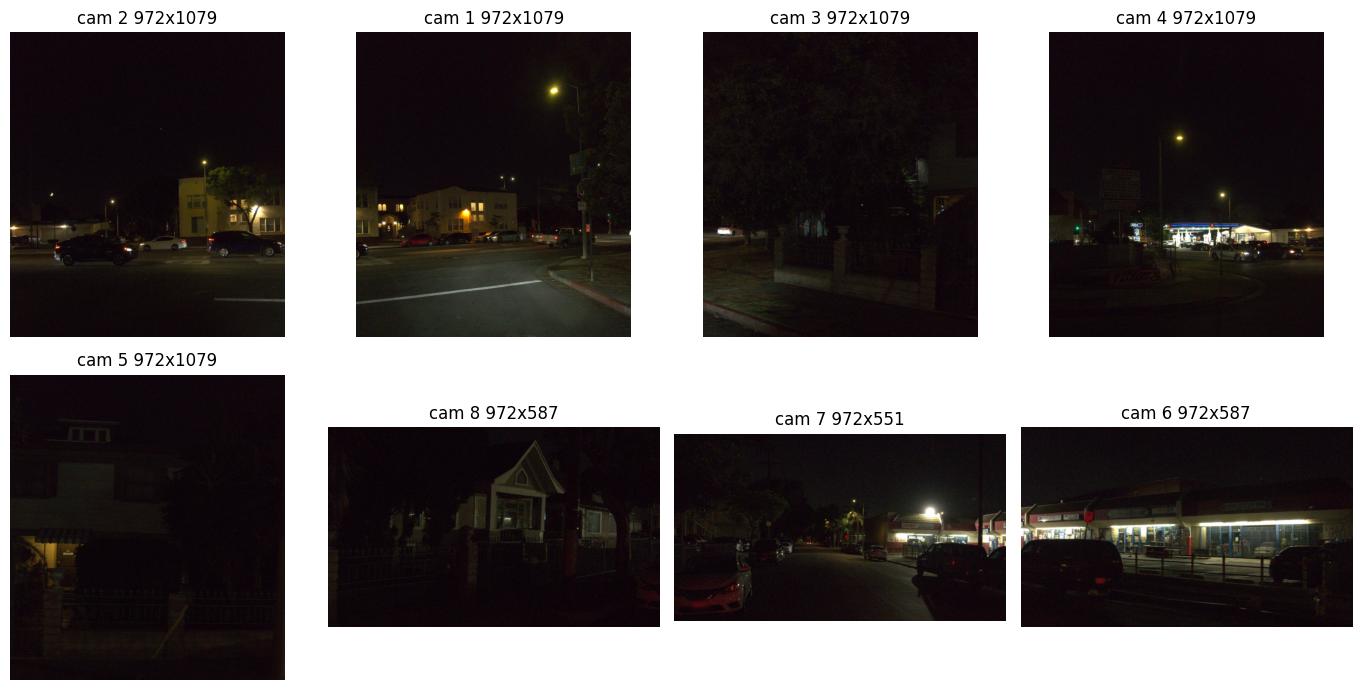

In [26]:
# NOTE: New cell - show raw images and sizes for all cameras in one frame
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

if 'frames' not in globals():
    raise RuntimeError('frames not found; run the sync-validation cell above first')

frame_idx = 0  # <-- choose frame
frame = frames[frame_idx]
base = frame.frame if hasattr(frame, 'frame') else frame

imgs = list(base.images)
print('frame_idx:', frame_idx, 'num_cameras:', len(imgs))

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for i, img_msg in enumerate(imgs[:8]):
    pil = Image.open(BytesIO(img_msg.image)).convert('RGB')
    w, h = pil.size
    cam_id = int(img_msg.name) if hasattr(img_msg, 'name') else i
    print(f'cam {cam_id}: size (h, w)=({h}, {w})')
    axes[i].imshow(pil)
    axes[i].set_title(f'cam {cam_id} {w}x{h}')
    axes[i].axis('off')

for j in range(len(imgs[:8]), 8):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [29]:
# NOTE: New cell - print distortion parameters per camera (from camera_calib.json if present)
import json
from pathlib import Path

# Update to your calibration file if needed
calib_path = Path('wod_export_Interections/Interections/Interections_segment-a9531d2b707f75a117280553930f312d/meta/camera_calib.json')
if not calib_path.exists():
    raise FileNotFoundError(f'calib_path not found: {calib_path}')

calib = json.loads(calib_path.read_text())
cameras = calib.get('cameras', {})

def extract_distortion(cam):
    keys = ['distortion', 'distortion_model', 'model', 'k1', 'k2', 'k3', 'p1', 'p2', 'k4', 'k5', 'k6']
    out = {}
    for k in keys:
        if k in cam:
            out[k] = cam[k]
    return out

for cam_id, cam in sorted(cameras.items(), key=lambda x: int(x[0])):
    dist = extract_distortion(cam)
    if dist:
        print(f'cam {cam_id}:', dist)
    else:
        print(f'cam {cam_id}: distortion params not found')


cam 1: distortion params not found
cam 2: distortion params not found
cam 3: distortion params not found
cam 4: distortion params not found
cam 5: distortion params not found
cam 6: distortion params not found
cam 7: distortion params not found
cam 8: distortion params not found


In [32]:
# NOTE: New cell - read distortion from raw frame context camera_calibrations (if present)
if 'frames' not in globals():
    raise RuntimeError('frames not found; run the sync-validation cell above first')

frame = frames[0]
base = frame.frame if hasattr(frame, 'frame') else frame

if not hasattr(base, 'context') or not hasattr(base.context, 'camera_calibrations'):
    raise AttributeError('no context.camera_calibrations in raw frame')

for calib in base.context.camera_calibrations:
    cam_id = calib.name if hasattr(calib, 'name') else 'unknown'
    intr = list(calib.intrinsic) if hasattr(calib, 'intrinsic') else []
    # Waymo intrinsic format: [fx, fy, cx, cy, k1, k2, p1, p2, k3] (if len >= 9)
    if len(intr) >= 9:
        fx, fy, cx, cy, k1, k2, p1, p2, k3 = intr[:9]
        print(f'cam {cam_id}: fx={fx:.3f} fy={fy:.3f} cx={cx:.3f} cy={cy:.3f} k1={k1:.6f} k2={k2:.6f} p1={p1:.6f} p2={p2:.6f} k3={k3:.6f}')
    else:
        print(f'cam {cam_id}: intrinsic len={len(intr)} ->', intr)


cam 2: fx=1113.963 fy=1113.826 cx=488.128 cy=719.156 k1=-0.073584 k2=-0.036582 p1=0.000000 p2=0.000000 k3=0.000000
cam 1: fx=1115.211 fy=1115.073 cx=488.128 cy=719.156 k1=-0.073584 k2=-0.036582 p1=0.000000 p2=0.000000 k3=0.000000
cam 3: fx=1111.109 fy=1110.973 cx=488.128 cy=719.156 k1=-0.073584 k2=-0.036582 p1=0.000000 p2=0.000000 k3=0.000000
cam 4: fx=1108.446 fy=1108.310 cx=488.128 cy=719.156 k1=-0.073584 k2=-0.036582 p1=0.000000 p2=0.000000 k3=0.000000
cam 5: fx=1110.930 fy=1110.793 cx=488.128 cy=719.156 k1=-0.073584 k2=-0.036582 p1=0.000000 p2=0.000000 k3=0.000000
cam 8: fx=1109.758 fy=1110.236 cx=488.128 cy=310.713 k1=-0.073584 k2=-0.036582 p1=0.000000 p2=0.000000 k3=0.000000
cam 7: fx=1113.047 fy=1112.495 cx=488.128 cy=310.425 k1=-0.073584 k2=-0.036582 p1=0.000000 p2=0.000000 k3=0.000000
cam 6: fx=1113.352 fy=1113.831 cx=488.128 cy=310.713 k1=-0.073584 k2=-0.036582 p1=0.000000 p2=0.000000 k3=0.000000


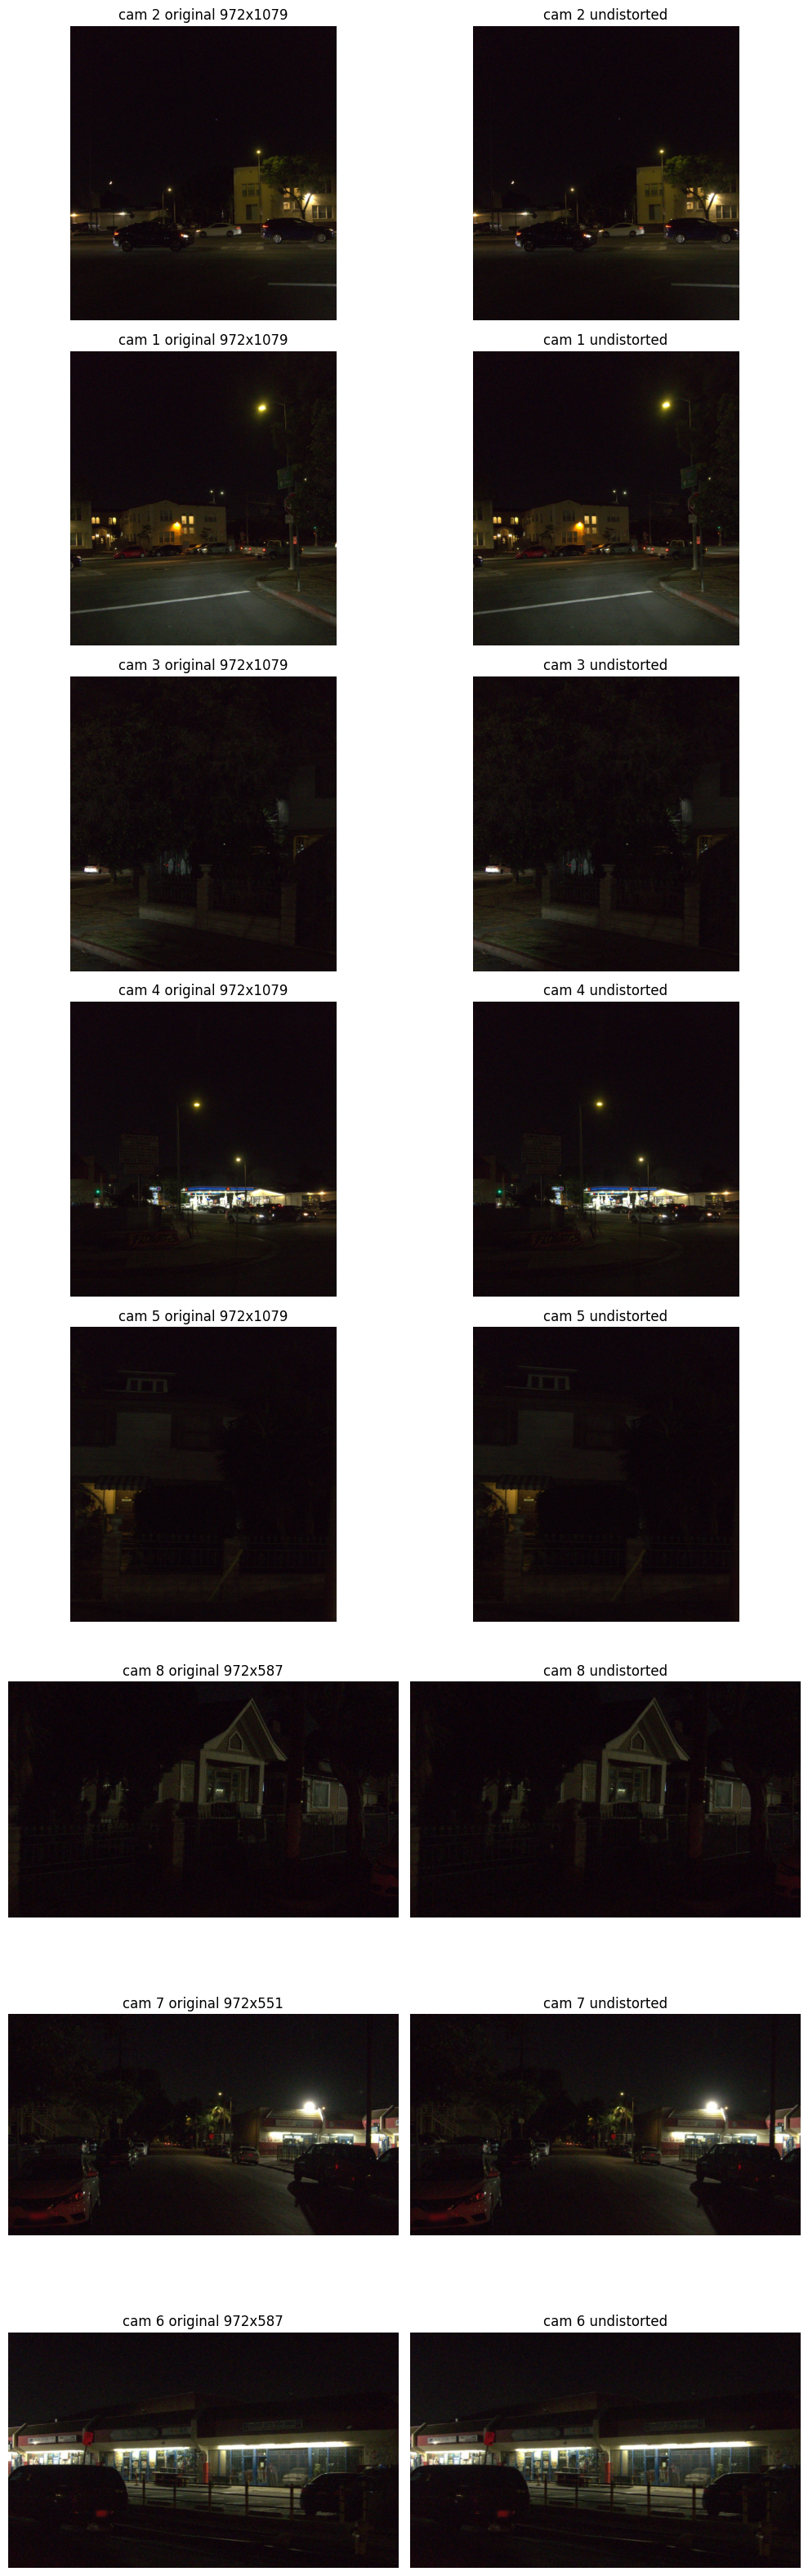

In [31]:
# NOTE: New cell - original vs undistorted comparison for 8 cameras
from io import BytesIO
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

try:
    import cv2
except ImportError as e:
    raise ImportError('cv2 is required for undistortion; please install opencv-python in this environment') from e

if 'frames' not in globals():
    raise RuntimeError('frames not found; run the sync-validation cell above first')

frame_idx = 0
frame = frames[frame_idx]
base = frame.frame if hasattr(frame, 'frame') else frame

if not hasattr(base, 'context') or not hasattr(base.context, 'camera_calibrations'):
    raise AttributeError('no context.camera_calibrations in raw frame')

# Build calibration map: cam_id -> (fx, fy, cx, cy, k1, k2, p1, p2, k3)
calib_map = {}
for calib in base.context.camera_calibrations:
    cam_id = int(calib.name) if hasattr(calib, 'name') else None
    intr = list(calib.intrinsic) if hasattr(calib, 'intrinsic') else []
    if cam_id is None or len(intr) < 9:
        continue
    calib_map[cam_id] = intr[:9]

def decode_image(img_msg):
    pil = Image.open(BytesIO(img_msg.image)).convert('RGB')
    return np.asarray(pil)

imgs = list(base.images)[:8]
num = len(imgs)
fig, axes = plt.subplots(num, 2, figsize=(10, 4 * num))
if num == 1:
    axes = np.array([axes])

for i, img_msg in enumerate(imgs):
    cam_id = int(img_msg.name) if hasattr(img_msg, 'name') else i
    img = decode_image(img_msg)
    h, w = img.shape[:2]

    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'cam {cam_id} original {w}x{h}')
    axes[i, 0].axis('off')

    intr = calib_map.get(cam_id)
    if intr is None:
        axes[i, 1].text(0.5, 0.5, f'no intrinsics for cam {cam_id}', ha='center', va='center')
        axes[i, 1].axis('off')
        continue

    fx, fy, cx, cy, k1, k2, p1, p2, k3 = intr
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype=np.float32)
    dist = np.array([k1, k2, p1, p2, k3], dtype=np.float32)

    # OpenCV expects BGR; convert RGB->BGR and back
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    und_bgr = cv2.undistort(img_bgr, K, dist)
    und = cv2.cvtColor(und_bgr, cv2.COLOR_BGR2RGB)

    axes[i, 1].imshow(und)
    axes[i, 1].set_title(f'cam {cam_id} undistorted')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()
